In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.special import jv, kv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [55]:
# import mc data file
mcfile = 'mc_data/mc_data_trial3_root_s40.npy'
mcdata = np.load(mcfile)
mc_df = pd.DataFrame(mcdata, columns=['s', 'Q', 'x', 'delta', 'pT', 'z', 'y', 'phi_kp', 'phi_Dp', 'dsa', 'unxsec'])


In [57]:
mc_df

,s,Q,x,delta,pT,z,y,phi_kp,phi_Dp,dsa,unxsec
0,1600.0,2.577075,0.004867,0.887603,7.155249,0.838432,0.852914,3.507816,5.853893,9.401082e-15,1.675922e-18
1,1600.0,2.848089,0.009482,0.882858,3.188082,0.435170,0.534689,4.548950,1.254598,-8.973921e-13,-6.849545e-16
2,1600.0,2.536654,0.004782,0.764197,7.719114,0.669390,0.840974,1.791903,5.817136,5.291852e-15,1.039084e-18
3,1600.0,2.536510,0.007186,0.349286,1.329337,0.664399,0.559559,1.231889,3.308490,-2.660723e-10,-4.484599e-13
4,1600.0,2.420511,0.004779,0.658793,1.761172,0.507316,0.766245,4.825206,1.239393,-6.421630e-11,-1.213982e-13
...,...,...,...,...,...,...,...,...,...,...,...
4995,1600.0,2.366236,0.004939,0.607846,7.072020,0.529103,0.708489,5.718166,1.109158,3.355121e-15,1.624985e-17
4996,1600.0,2.399181,0.008742,0.973290,7.306071,0.829103,0.411536,3.735335,5.381089,2.449949e-14,2.900526e-18
4997,1600.0,2.905063,0.009895,0.779266,1.763434,0.535342,0.533066,3.064842,2.575311,-2.266756e-11,8.456471e-14
4998,1600.0,2.649045,0.005972,0.315131,1.848455,0.867891,0.734431,0.638498,4.454145,-7.410806e-11,1.117352e-14


In [59]:
# function to plot histograms

def plot_histogram(df, plot_q, constraints, vary_q=None, **options):

    fig, (ax, ax_info) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [5, 1]})

    # make bins
    range = [df[plot_q].min(), df[plot_q].max()]
    nbins = options.get('nbins', 10)
    bin_width = options.get('binwidth', (range[1] - range[0])/nbins)
    bins = np.arange(np.floor(range[0]/bin_width)*bin_width, np.ceil(range[1]/bin_width)*bin_width + bin_width, bin_width)

    # enforce constraints
    mask = pd.Series(True, index=df.index)
    for var, (low, high) in constraints.items(): mask &= df[var].between(low, high)
    fixed_df = df[mask]



    # make plot data
    if vary_q:
        var, values = list(vary_q.items())[0]
        for value in values:
            vfixed_df = fixed_df[fixed_df[var].between(value*0.99, value*1.01)] # default here is requested value is within 1%
            
            # counts, plot_bins = np.histogram(vfixed_df[plot_q], bins=bins, weights=vfixed_df['dsa'])
            counts, plot_bins = np.histogram(vfixed_df[plot_q], bins=bins)
            bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])
            bin_widths = 0.5*(plot_bins[1:]-plot_bins[:-1])
            errors = np.sqrt(counts) # poisson error
            
            ax.errorbar(
                bin_centers, counts, yerr=errors, xerr=bin_widths,
                fmt=options.get('fmt', 'o'), label=options.get('label', fr'${var} = {value}\pm{value*0.01}$'), capsize=3, elinewidth=1, capthick=1
            )
        ax.legend()
            
    else: 
        # counts, plot_bins = np.histogram(fixed_df[plot_q], bins=bins, weights=fixed_df['dsa'])
        counts, plot_bins = np.histogram(fixed_df[plot_q], bins=bins)
        bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])
        bin_widths = 0.5*(plot_bins[1:]-plot_bins[:-1])
        errors = np.sqrt(counts) # poisson error
        
        ax.errorbar(
            bin_centers, counts, yerr=errors, xerr=bin_widths,
            fmt=options.get('fmt', 'o'), label=options.get('label', ''), capsize=3, elinewidth=1, capthick=1
        )

    # make info box for constraints
    info_text = 'Constraints:\n'
    for var, (low, high) in constraints.items():
        info_text += fr'${var}: [{low}, {high}]$'+'\n'
    ax_info.text(
        -0.3, 0.85, info_text, 
        ha='left', va='bottom', 
        fontsize=12, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3)
    )
    ax_info.set_axis_off()

    # set plot info
    if options.get('y_limits'): ax.set_ylim(options.get('y_limits'))
    if options.get('x_limits'): ax.set_ylim(options.get('x_limits'))
    ax.set_title(options.get('title', f'{plot_q} frequency'))
    ax.set_ylabel(options.get('y_label', 'Frequency'))
    ax.set_xlabel(options.get('x_label', fr'${plot_q}$'))
    ax.set_yscale(options.get('y_scale', 'linear'))
    ax.set_xscale(options.get('x_scale', 'linear'))
    ax.grid(options.get('grid', True)) 



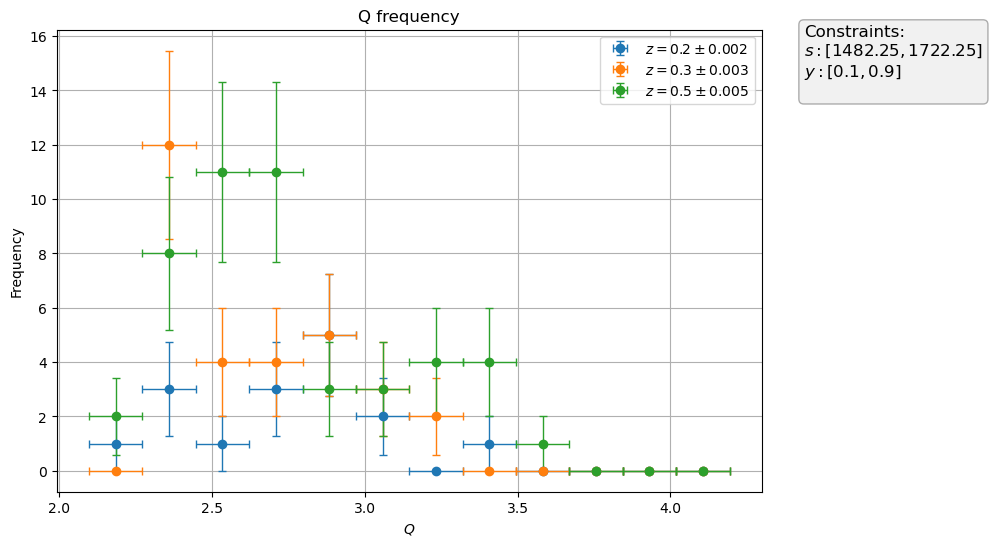

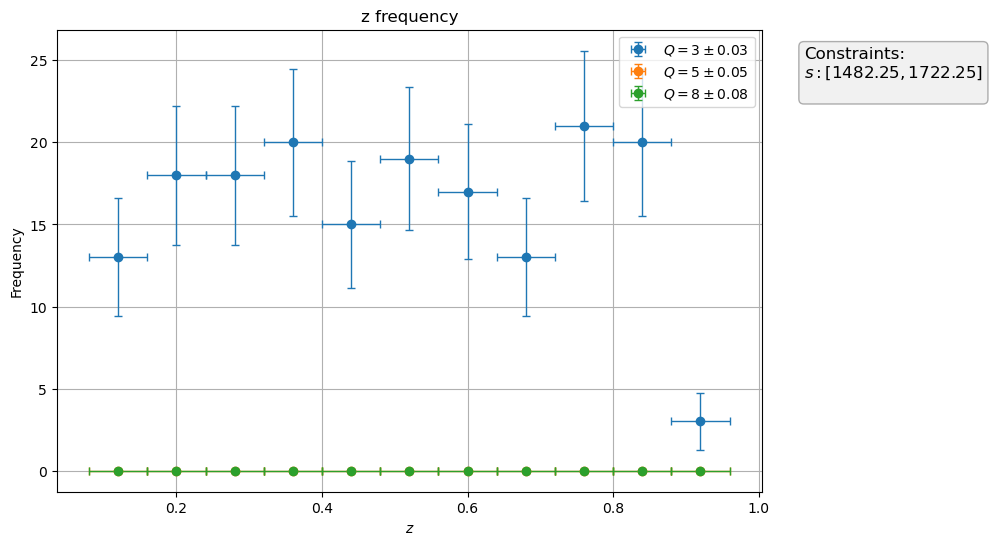

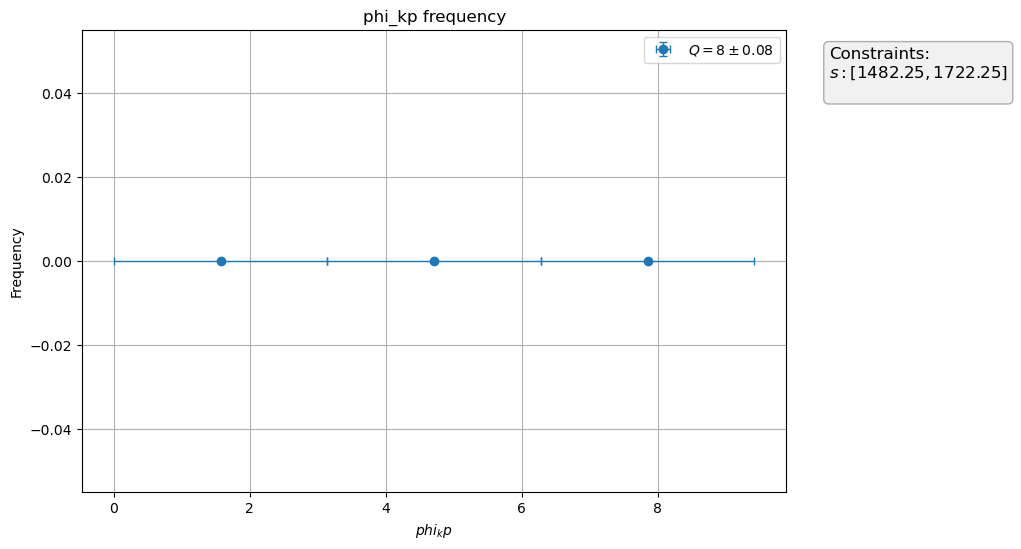

In [63]:
plot_s = 40
delta_s = 1.5

plot_histogram(mc_df, 'Q', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2], 'y':[0.1, 0.9]}, vary_q={'z': [0.2, 0.3, 0.5]})
plot_histogram(mc_df, 'z', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2]}, vary_q={'Q': [3, 5, 8]})

plot_histogram(mc_df, 'phi_kp', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2]}, vary_q={'Q': [8]}, nbins=2)



